In [1]:
from os.path import expanduser

import datamol as dm
import lightgbm as lgb
import numpy as np
import pandas as pd
from molfeat.trans import MoleculeTransformer
from molfeat.trans.fp import FPVecTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from openadmet_models.anvil.anvil_workflow import AnvilSpecification

### Convert target data to categorical

In [2]:
# Configure database and threshold
db = "ache_chembl"
conc_thresh = 30  # uM
pchembl_thresh = -np.log10(conc_thresh * 1e-6)

# Construct data frame
df = pd.read_parquet(expanduser(f"~/sandbox/databases/{db}/source/{db}.parquet"))
df["is_active"] = df["pchembl_value"] > pchembl_thresh

# Stats
print("Conc:\t\t{:.1f} uM".format(conc_thresh))
print("Threshold:\t{:.2f}".format(pchembl_thresh))
print("N negatives:\t{}".format(np.sum(df["pchembl_value"] <= pchembl_thresh)))
print(
    "frac negatives:\t{:.3f}%".format(
        100 * np.sum(df["pchembl_value"] <= pchembl_thresh) / len(df)
    )
)

Conc:		30.0 uM
Threshold:	4.52
N negatives:	503
frac negatives:	8.281%


### "Manual" classification

In [3]:
X = df["PARENT_SMILES"].values
y = df["is_active"].values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
vec_featurizer = FPVecTransformer("ecfp:4", dtype=np.float32)
trans = MoleculeTransformer(
    vec_featurizer,
    n_jobs=-1,
    dtype=np.float32,
    parallel_kwargs={"progress": True},
    verbose=False,
)

with dm.without_rdkit_log():
    X_train_feat, _ = trans(X_train, ignore_errors=True)
    X_test_feat, _ = trans(X_test, ignore_errors=True)

X_train_feat = np.squeeze(X_train_feat)
X_test_feat = np.squeeze(X_test_feat)


In [5]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train_feat, label=y_train)
test_data = lgb.Dataset(X_test_feat, label=y_test, reference=train_data)

# Set model parameters
params = {
    "objective": "binary",
    "metric": "binary_error",
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "verbose": -1,
}

# Train model
model = lgb.train(
    params,
    train_data,
    valid_sets=[test_data],
    num_boost_round=100,
)

# Predict on test set
y_pred = (model.predict(X_test_feat) > 0.5).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
null = np.sum(y_test) / len(y_test)

print(f"Accuracy: {accuracy:.4f}")
print(f"Null accuracy: {null:.4f}")

Accuracy: 0.9184
Null accuracy: 0.9184


### Run basic anvil (regression)

[03/24/25 11:16:07] INFO     Making workflow from specification                               ]8;id=123142;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=927666;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#189\189]8;;\

                    INFO     Running workflow from directory output/_2025-03-24_2934d2        ]8;id=396452;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=996215;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#256\256]8;;\

                    INFO     Running with driver sklearn                                      ]8;id=658564;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=987025;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#258\258]8;;\

                    INFO     Loading data                                                     ]8;id=915941;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=934133;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#260\260]8;;\

                    INFO     Data loaded                                                      ]8;id=721885;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=10059;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#262\262]8;;\

                    INFO     Transforming data                                                ]8;id=720470;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=601090;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#264\264]8;;\

                    INFO     No transform specified, skipping                                 ]8;id=845283;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=739365;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#269\269]8;;\

                    INFO     Splitting data                                                   ]8;id=516112;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=847054;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#271\271]8;;\

                    INFO     Data split                                                       ]8;id=942329;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=373491;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#279\279]8;;\

                    INFO     Featurizing data                                                 ]8;id=845628;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=946106;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#281\281]8;;\

/Users/smcolby/opt/miniforge3/envs/compchem/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/smcolby/opt/miniforge3/envs/compchem/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/smcolby/opt/miniforge3/envs/compchem/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/smcolby/opt/miniforge3/envs/compchem/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/smcolby/opt/miniforge3/envs/compchem/lib/python3.12/site-packages/sklearn/utils/d

[03/24/25 11:16:08] INFO     Data featurized                                                  ]8;id=535323;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=956386;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#287\287]8;;\

                    INFO     Building model                                                   ]8;id=740761;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=765236;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#289\289]8;;\

                    INFO     Model built                                                      ]8;id=527025;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=320675;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#291\291]8;;\

                    INFO     Setting model in trainer                                         ]8;id=129280;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=515580;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#293\293]8;;\

                    INFO     Model set in trainer                                             ]8;id=904702;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=592607;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#295\295]8;;\

                    INFO     Training model                                                   ]8;id=407565;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=372517;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#297\297]8;;\

[03/24/25 11:16:09] INFO     Model trained                                                    ]8;id=923571;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=963622;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#299\299]8;;\

                    INFO     Saving model                                                     ]8;id=275612;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=747098;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#301\301]8;;\

                    INFO     Model saved                                                      ]8;id=183091;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=324997;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#303\303]8;;\

                    INFO     Predicting                                                       ]8;id=887536;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=898565;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#305\305]8;;\

/Users/smcolby/opt/miniforge3/envs/compchem/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


                    INFO     Predictions made                                                 ]8;id=915471;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=205921;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#307\307]8;;\

                    INFO     Evaluating                                                       ]8;id=199336;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=630761;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#309\309]8;;\

[03/24/25 11:16:24] INFO     Evaluation done                                                  ]8;id=759849;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py\anvil_workflow.py]8;;\:]8;id=941569;file:///Users/smcolby/repos/openadmet_models/openadmet_models/anvil/anvil_workflow.py#320\320]8;;\

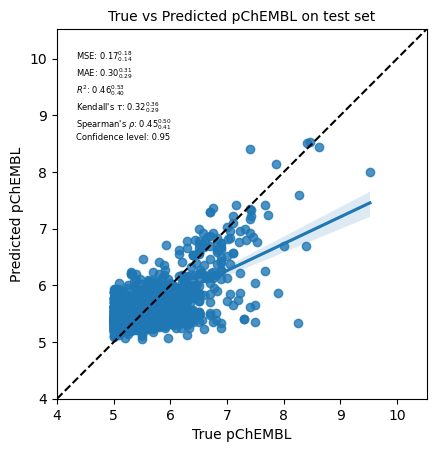

In [6]:
spec = AnvilSpecification.from_recipe("anvil_recipe.yaml")
wf = spec.to_workflow()
wf.run(debug=False, output_dir="output/")